## CW generation.


In [1]:
! pip install pmcx
! pip install numpy pmcx jdata bjdata matplotlib

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.0/65.0 kB 6.2 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for bjdata: filename=bjdata-0.4.1-cp311-cp311-linux_x86_64.whl size=22196 sha256=53316806903e626224481aff31f9547a0c0e94e9cb57ad4072f111bab14d0964
  Stored in directory: /root/.cache/pip/wheels/e4/d5/4a/8d5ccb70c0eb1f07a10da8548e50b7fc0cbdfd014f5eaa45c3
Successfully built bjdata


In [2]:
from google.colab import drive
drive.mount('/content/drive')
import sys
import os
import pmcx
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pickle
import math
import io

Mounted at /content/drive


In [3]:
# Path to your folder containing the .py script
folder_path = '/content/drive/MyDrive/MCX_data'

# Add to sys.path so you can import the script
if folder_path not in sys.path:
    sys.path.append(folder_path)
from FD_msNIRS import mcx_simulation as ms
from FD_msNIRS import extract_freq as ef

In [4]:
!ls '/content/drive/MyDrive/MCX_data'

2_L_30_mu_as_df.csv	       EC.xlsx	     __pycache__
2_L_30_mu_s_primes_df.csv.csv  FD_msNIRS.py


In [5]:
pmcx.gpuinfo()

[{'name': 'NVIDIA A100-SXM4-40GB',
  'id': 1,
  'devcount': 1,
  'major': 8,
  'minor': 0,
  'globalmem': 42474471424,
  'constmem': 65536,
  'sharedmem': 49152,
  'regcount': 65536,
  'clock': 1410000,
  'sm': 108,
  'core': 6912,
  'autoblock': 64,
  'autothread': 442368,
  'maxgate': 0}]

### concentration -> Ua and Us

### Ua

In [6]:
HbO2_mean = 60  # microMolar
Hb_mean = 25    # microMolar
CCO_mean = 8.5    # microMolar
concentrations_true = np.array([HbO2_mean, Hb_mean, CCO_mean])
C_true = concentrations_true / 1e6

In [7]:
lambdas = [784, 800, 818, 835, 851, 868, 881, 894]

In [8]:
extinction_coeffs = pd.read_excel(folder_path + "/EC.xlsx")
extinction_coeffs_filtered = extinction_coeffs[extinction_coeffs['Lambda'].isin(lambdas)]

In [9]:
E3 = extinction_coeffs_filtered[['HbO2', 'Hb','CCO']].values
E3 = E3 * math.log(10)
E3.shape

(8, 3)

In [10]:
mu_a = np.dot(C_true, E3.T)

In [11]:
mu_a

array([0.20474467, 0.21210724, 0.22618976, 0.2393086 , 0.25090614,
       0.26090535, 0.26660143, 0.27055057])

### Us

In [12]:
a = 22
b = 1.2
mu_s_prime = np.array([a * (wavelength / 500) ** (-b) for wavelength in lambdas])

In [13]:
mu_s_prime

array([12.82352465, 12.5163789 , 12.18660463, 11.8894815 , 11.62174157,
       11.34914163, 11.14847838, 10.95422516])

### MCX Simulation using packgae

In [14]:
g=0.85
distance = [2, 2.5, 3.0 ,3.5]
distance_mm = [d * 10 for d in distance]  # mm
distance_data = {d: [] for d in distance_mm}

for sim_idx, (ua_row, us_p_row) in enumerate(zip(mu_a, mu_s_prime)):
    us = us_p_row / (1 - g)
    ua_mm = ua_row / 10
    us_mm = us / 10
    print('ua_mm = ', ua_mm)
    print('us_mm = ', us_mm)
    print(f"\n--- Simulation {sim_idx + 1} ---")

    # -------- Simulation for Multi-Distances --------------
    TPSF_list, time_unit = ms(ua_mm, us_mm, g=0.85, n=1.370, distance=distance_mm, tend=1e-08, devf=1, nphoton=1.2e6)
    [[x[0] * 1.2e6 * 1e-08 ] for x in TPSF_list] # weight/mm2
    for i, d in enumerate(distance_mm):
        distance_data[d].append(TPSF_list[i][0])

ua_mm =  0.02047446691247822
us_mm =  8.549016430272166

--- Simulation 1 ---
nphoton: 1.2e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1.2e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua_mm =  0.0212107242524258
us_mm =  8.344252597202866

--- Simulation 2 ---
nphoton: 1.2e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1.2e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua_mm =  0.022618976084960586
us_mm =  8.124403088071144

--- Simulation 3 ---
nphoton: 1.2e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1.2e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua_mm =  0.02393086012618339
us_mm =  7.9263209997313

--- Simulation 4 ---
nphoton: 1.2e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
maxdetphoton: 1.2e+06
issrcfrom0: 1
autopilot: 1
unitinmm: 1
issaveref: 1
issavedet: 1
ua_mm =  0.025090613521604615
us_mm =  7.7478277136993485

--- Simulation 5 ---
nphoton: 1.2e+06
tstart: 0
tstep: 1e-08
tend: 1e-08
ma

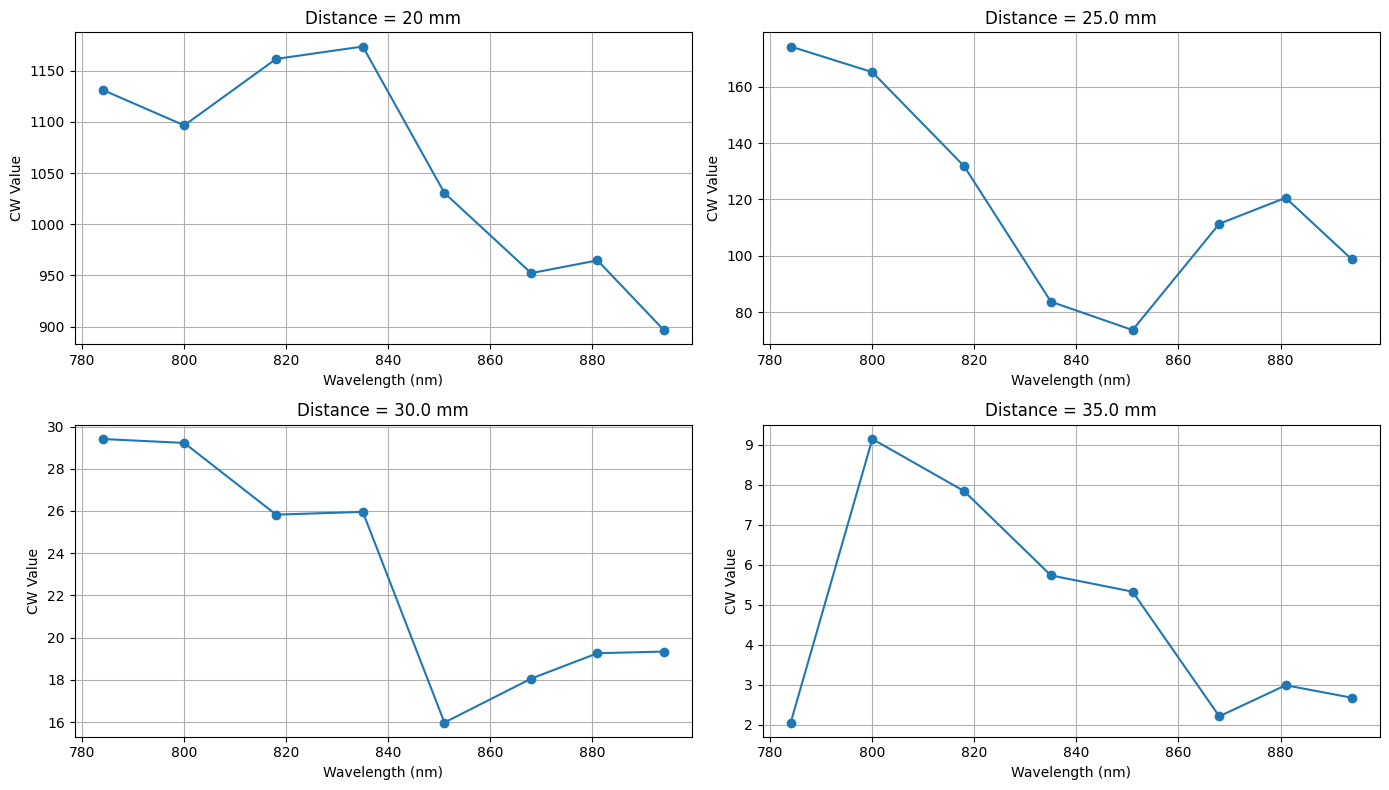

In [15]:
fig, axs = plt.subplots(2, 2, figsize=(14, 8))
axs = axs.flatten()

for idx, (distance, values) in enumerate(distance_data.items()):
    axs[idx].plot(lambdas, values, marker='o')
    axs[idx].set_title(f'Distance = {distance} mm')
    axs[idx].set_xlabel('Wavelength (nm)')
    axs[idx].set_ylabel('CW Value')
    axs[idx].grid(True)

plt.tight_layout()
plt.show()